In [1]:
! pip install tensorflow
! pip install pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib

   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
   - -------------------------------------- 8.9/331.7 MB 50.3 MB/s eta 0:00:07
   -- ------------------------------------- 21.8/331.7 MB 59.7 MB/s eta 0:00:06
   -- ------------------------------------- 23.1/331.7 MB 40.5 MB/s eta 0:00:08
   --- ------------------------------------ 25.4/331.7 MB 31.6 MB/s eta 0:00:10
   --- ------------------------------------ 29.6/331.7 MB 28.4 MB/s eta 0:00:11
   --- ------------------------------------ 32.2/331.7 MB 25.9 MB/s eta 0:00:12
   ---- ----------------------------------- 34.9/331.7 MB 24.1 MB/s eta 0:00:13
   ---- ----------------------------------- 38.0/331.7 MB 23.0 MB/s eta 0:00:13
   ---- ----------------------------------- 40.6/331.7 MB 21.7 MB/s eta 0:00:14
   ----- ---------------------------------- 43.0/331.7 MB 20.7 MB/s eta 0:00:14
   ----- ---------------------------------- 45.1/331.7 MB 19.6 MB/s eta 0:00:15
   ----- ---------------------------------- 47.2/3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 2.20.0 requires protobuf<4, but you have protobuf 6.33.2 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preparacion de Datos

### Separacion de Datasets

In [3]:
import pandas as pd
import numpy as np
import os

file_dict = {
    25037: {'Clasificacion': 'Seco', 'ruta_origen': '../data/data_conagua_clasificada/Seco/NR_25037.csv', 'ruta_salida': './TensorFlow_dataset_splits/Seco/NR_25037/'},
    25033: {'Clasificacion': 'Templado', 'ruta_origen': '../data/data_conagua_clasificada/Templado/NR_25033.csv', 'ruta_salida': './TensorFlow_dataset_splits/Templado/NR_25033/'},
    25046: {'Clasificacion': 'Tropical', 'ruta_origen': '../data/data_conagua_clasificada/Tropical/NR_25046.csv', 'ruta_salida': './TensorFlow_dataset_splits/Tropical/NR_25046/'}
}

TRAIN_RATIO = 0.70
TEST_RATIO = 0.20

columnas_objetivo = ['PRECIP','EVAP','TMAX','TMIN']

for file_id, file_info in file_dict.items():
    ruta_origen = file_info['ruta_origen']
    ruta_salida_base = file_info['ruta_salida']
    
    
    df = pd.read_csv(ruta_origen, index_col=0, parse_dates=True).asfreq('D')
    df = df.sort_index()
    df = df.asfreq('D')
    
    total_rows = len(df)
    
    train_end = int(total_rows * TRAIN_RATIO)
    test_end = int(total_rows * (TRAIN_RATIO + TEST_RATIO))
    
    df_train = df.iloc[:train_end]
    df_test = df.iloc[train_end:test_end]
    df_val = df.iloc[test_end:]
    
    splits = {'train':{'df': df_train, 'ruta_salida': os.path.join(ruta_salida_base, 'train')},
              'test': {'df': df_test, 'ruta_salida': os.path.join(ruta_salida_base, 'test')},
              'val':  {'df': df_val, 'ruta_salida': os.path.join    (ruta_salida_base, 'val')}}
    
    for split_name, split_info in splits.items():
        save_path = split_info['ruta_salida']
        os.makedirs(save_path, exist_ok=True)
        
        print(f"Guardando {split_name} data en {save_path}")
        split_info['df'].to_csv(os.path.join(save_path, f"{split_name}_data.csv"))


Guardando train data en ./TensorFlow_dataset_splits/Seco/NR_25037/train
Guardando test data en ./TensorFlow_dataset_splits/Seco/NR_25037/test
Guardando val data en ./TensorFlow_dataset_splits/Seco/NR_25037/val
Guardando train data en ./TensorFlow_dataset_splits/Templado/NR_25033/train
Guardando test data en ./TensorFlow_dataset_splits/Templado/NR_25033/test
Guardando val data en ./TensorFlow_dataset_splits/Templado/NR_25033/val
Guardando train data en ./TensorFlow_dataset_splits/Tropical/NR_25046/train
Guardando test data en ./TensorFlow_dataset_splits/Tropical/NR_25046/test
Guardando val data en ./TensorFlow_dataset_splits/Tropical/NR_25046/val


### Escalado de datos

In [12]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import MinMaxScaler

WINDOW_SIZE = 30 # Tamaño de la ventana deslizante
STEP_SIZE = 1    # Paso de la ventana deslizante
COLUMNAS_OBJETIVO = ['PRECIP','EVAP','TMAX','TMIN']

directorio = {
    25037: {'Clasificacion': 'Seco', 'ruta_base': './TensorFlow_dataset_splits/Seco/NR_25037/','ruta_saliente': './Tensorflow_data_escalada/Seco/NR_25037/'},
    25033: {'Clasificacion': 'Templado', 'ruta_base': './TensorFlow_dataset_splits/Templado/NR_25033/','ruta_saliente': './Tensorflow_data_escalada/Templado/NR_25033/'},
    25046: {'Clasificacion': 'Tropical', 'ruta_base': './TensorFlow_dataset_splits/Tropical/NR_25046/','ruta_saliente': './Tensorflow_data_escalada/Tropical/NR_25046/'}
}

for file_id, paths in directorio.items():
    ruta_base = paths['ruta_base']
    ruta_salida_base = paths['ruta_saliente']
    
    os.makedirs(ruta_salida_base, exist_ok=True)
    
    for split in ['train', 'test', 'val']:
        ruta_split = os.path.join(ruta_base, split, f"{split}_data.csv")
        df = pd.read_csv(ruta_split, index_col=0, parse_dates=True).asfreq('D')
        df = df[COLUMNAS_OBJETIVO].fillna(0) # Llenar NaNs con 0 para escalado
        df = df.sort_index()
        
        scaler = MinMaxScaler()
        scaler.fit(df)
        
        df_scaled = pd.DataFrame(scaler.transform(df), columns = COLUMNAS_OBJETIVO, index=df.index)
        
        ruta_csv = os.path.join(ruta_salida_base, split,'data', f"{split}_data_scaled.csv")
        os.makedirs(os.path.join(ruta_salida_base, split, 'data'), exist_ok=True)
        df_scaled.to_csv(ruta_csv)
        
        ruta_scaler = os.path.join(ruta_salida_base, 'scaler')
        
        os.makedirs(os.path.join(ruta_scaler), exist_ok=True)
        joblib.dump(scaler, os.path.join(ruta_scaler, f'scaler_{split}.joblib.pkl'))
        
        data_values = df_scaled.values
        Xs =[]
        
        num_muestras = len(data_values) - WINDOW_SIZE 
        
        if num_muestras > 0:
            for i in range(0, len(data_values) - WINDOW_SIZE, STEP_SIZE):
                ventana = data_values[i : (i + WINDOW_SIZE)]
                Xs.append(ventana)
            
        X_tensor = np.array(Xs)
        
        ruta_tensor = os.path.join(ruta_salida_base, split,'tensor' ,f"{split}_data_tensor.npy")
        os.makedirs(os.path.dirname(ruta_tensor), exist_ok=True)
        np.save(ruta_tensor, X_tensor)
        
        

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,660 (526.02 KB)

 Trainable params: 134,660 (526.02 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando modelo para la estación 25037...
Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0387
Epoch 1: loss improved from None to 0.01870, saving model to ./Modelos_Tensorflow/Seco/NR_25037/AE_BiLSTM_estacion_25037.keras
290/290 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - loss: 0.0187
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0083
Epoch 2: loss improved from 0.01870 to 0.00800, saving model to ./Modelos_Tensorflow/Seco/NR_25037/AE_BiLSTM_estacion_25037.keras
290/290 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.0080
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0074
Epoch 3: loss improved from 0.00800 to 0.00716, saving model to ./Modelos_Tensorflow/Seco/NR_25037/AE_BiLSTM_estacion_25037.keras
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 0.0072
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0067
Epoch 4: loss improved from 0.00716 to 0.00670, saving model to ./Modelos_Tensorflow/Seco/NR_25037/AE_BiLSTM_estacion

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,660 (526.02 KB)

 Trainable params: 134,660 (526.02 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando modelo para la estación 25033...
Epoch 1/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0467
Epoch 1: loss improved from None to 0.02178, saving model to ./Modelos_Tensorflow/Templado/NR_25033/AE_BiLSTM_estacion_25033.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0218
Epoch 2/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0093
Epoch 2: loss improved from 0.02178 to 0.00884, saving model to ./Modelos_Tensorflow/Templado/NR_25033/AE_BiLSTM_estacion_25033.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0088
Epoch 3/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0077
Epoch 3: loss improved from 0.00884 to 0.00765, saving model to ./Modelos_Tensorflow/Templado/NR_25033/AE_BiLSTM_estacion_25033.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0076
Epoch 4/100
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0072
Epoch 4: loss improved from 0.00765 to 0.00709, saving model to ./Modelos_Tensorflow/Templado/NR_25033/AE_B

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,660 (526.02 KB)

 Trainable params: 134,660 (526.02 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando modelo para la estación 25046...
Epoch 1/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0373
Epoch 1: loss improved from None to 0.01712, saving model to ./Modelos_Tensorflow/Tropical/NR_25046/AE_BiLSTM_estacion_25046.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0171
Epoch 2/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0074
Epoch 2: loss improved from 0.01712 to 0.00702, saving model to ./Modelos_Tensorflow/Tropical/NR_25046/AE_BiLSTM_estacion_25046.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.0070
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0064
Epoch 3: loss improved from 0.00702 to 0.00629, saving model to ./Modelos_Tensorflow/Tropical/NR_25046/AE_BiLSTM_estacion_25046.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.0063
Epoch 4/100
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0060
Epoch 4: loss improved from 0.00629 to 0.00593, saving model to ./Modelos_Tensorflow/Tropical/NR_25046/AE_B

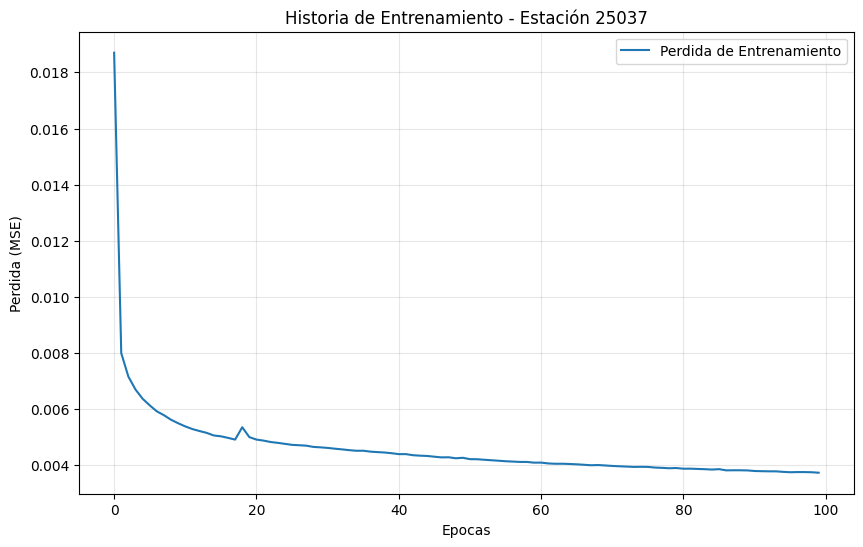

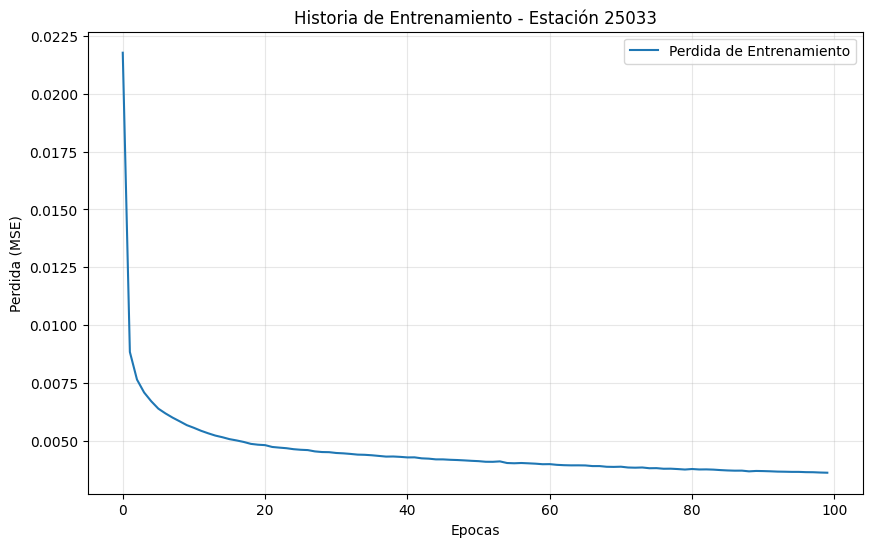

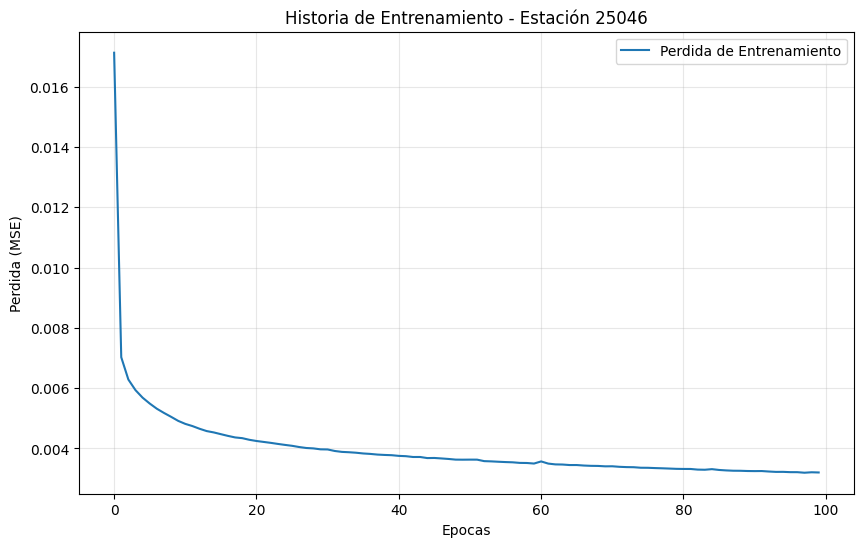

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt

INPUT_SHAPE = (30, 4) # 30 dias, 4 variables
LATENT_DIM = 64       # Tamaño del vector comprimido 
BATCH_SIZE = 64       # Procesar 64 muestras a la vez (Estandar para estabilidad)
EPOCHS = 100          # Maximo de epocas 
MASKING_RATE = 0.2    # Romper el 20% de los datos para entrenar 
LEARNING_RATE = 0.001


directorio = {
    25037: {'Clasificacion': 'Seco', 'path': 'Seco/NR_25037',
            'Direccion_data': './Tensorflow_data_escalada/Seco/NR_25037/train/data',
            'direccion_tensor': './Tensorflow_data_escalada/Seco/NR_25037/train/tensor',
            'direccion_modelo': './Modelos_Tensorflow/Seco/NR_25037/'},
    
    25033: {'Clasificacion': 'Templado', 'path': 'Templado/NR_25033', 
            'Direccion_data': './Tensorflow_data_escalada/Templado/NR_25033/train/data',
            'direccion_tensor': './Tensorflow_data_escalada/Templado/NR_25033/train/tensor',
            'direccion_modelo': './Modelos_Tensorflow/Templado/NR_25033/'},
    
    25046: {'Clasificacion': 'Tropical', 'path': 'Tropical/NR_25046', 
            'Direccion_data': './Tensorflow_data_escalada/Tropical/NR_25046/train/data',
            'direccion_tensor': './Tensorflow_data_escalada/Tropical/NR_25046/train/tensor',
            'direccion_modelo': './Modelos_Tensorflow/Tropical/NR_25046/'}
    
}


for estacion, info in directorio.items():
    ruta_data = info['Direccion_data']
    ruta_tensor = info['direccion_tensor']
    ruta_salida_modelo = info['direccion_modelo']
    os.makedirs(ruta_salida_modelo, exist_ok=True)
    
    # Cargar datos de entrenamiento
    X_train = np.load(os.path.join(ruta_tensor, 'train_data_tensor.npy'))
    
    X_train_ruido = X_train.copy()
    mascara = np.random.rand(*X_train_ruido.shape) < MASKING_RATE
    X_train_ruido[mascara] = 0
    
    #Limpiar sesión previa
    tf.keras.backend.clear_session()
    
    inputs = Input(shape=INPUT_SHAPE)
    
    # Encoder
    encoded = Bidirectional(LSTM(LATENT_DIM, activation='relu', return_sequences=False))(inputs)
    encoded = Dropout(0.2)(encoded)
    
    
    decoded = RepeatVector(INPUT_SHAPE[0])(encoded)
    
    decoded = Bidirectional(LSTM(LATENT_DIM, activation='relu', return_sequences=True))(decoded)
    decoded = Dropout(0.2)(decoded)
    
    outputs = TimeDistributed(Dense(INPUT_SHAPE[1]))(decoded)
    
    
    modelo = Model(inputs, outputs)

    modelo.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
    
    modelo.summary()
    
    
    camino_salida = os.path.join(ruta_salida_modelo, f'AE_BiLSTM_estacion_{estacion}.keras')
    
    checkpoint = ModelCheckpoint(camino_salida, monitor='loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
    
    print(f"Entrenando modelo para la estación {estacion}...")
    historia = modelo.fit(
        X_train_ruido, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    # Guardar historia de entrenamiento
    historia_path = os.path.join(ruta_salida_modelo, f'historia_entrenamiento_estacion_{estacion}.npy')
    np.save(historia_path, historia.history)
    # Graficar historia de entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(historia.history['loss'], label='Perdida de Entrenamiento')
    plt.title(f'Historia de Entrenamiento - Estación {estacion}')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida (MSE)')
    plt.legend()
    plt.grid(True,alpha=0.3)
    
    plot_path = os.path.join(ruta_salida_modelo, f'historia_entrenamiento_estacion_{estacion}.png')
    plt.savefig(plot_path)
    
    print(f"Modelo entrenado y guardado en {camino_salida}")
    

## Testing de modelo

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

BATCH_SIZE = 64
MASKING_RATE = 0.2  # 20% de datos borrados
COLUMNAS = ['PRECIP', 'EVAP', 'TMAX', 'TMIN']

# Definición de Bins 
bins = [0, 3, 7, 31, 180, 365, 730, float('inf')]
labels = ['1-3 Dias', '4-7 Dias', '8-31 Dias', '32-180 Dias', '181-365 Dias', '1-2 Años', '>2 Años']



directorio = {
    25037: {
        'Clasificacion': 'Seco', 
        'direccion_tensor': './Tensorflow_data_escalada/Seco/NR_25037/test/tensor', 
        'direccion_scaler': './Tensorflow_data_escalada/Seco/NR_25037/scaler/scaler_test.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Seco/NR_25037/',
        'direccion_salida_analisis': './data_analysis/test/Performance_metrics/Seco/NR_25037/'
    },
    25033: {
        'Clasificacion': 'Templado', 
        'direccion_tensor': './Tensorflow_data_escalada/Templado/NR_25033/test/tensor',
        'direccion_scaler': './Tensorflow_data_escalada/Templado/NR_25033/scaler/scaler_test.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Templado/NR_25033/',
        'direccion_salida_analisis': './data_analysis/test/Performance_metrics/Templado/NR_25033/'
    },
    25046: {
        'Clasificacion': 'Tropical', 
        'direccion_tensor': './Tensorflow_data_escalada/Tropical/NR_25046/test/tensor',
        'direccion_scaler': './Tensorflow_data_escalada/Tropical/NR_25046/scaler/scaler_test.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Tropical/NR_25046/',
        'direccion_salida_analisis': './data_analysis/test/Performance_metrics/Tropical/NR_25046/'
    }
}

print("INICIANDO TESTING DE IMPUTACION CON HORIZONTES")

for estacion, info in directorio.items():
    print(f"Evaluando Estacion: {estacion}")
    
    ruta_tensor_base = info['direccion_tensor']

    file_tensor = os.path.join(ruta_tensor_base, 'test_data_tensor.npy') 
    
    
    
    ruta_scaler = info['direccion_scaler']
    ruta_modelo = os.path.join(info['direccion_modelo'], f'AE_BiLSTM_estacion_{estacion}.keras')
    
    X_test = np.load(file_tensor) 
    scaler = joblib.load(ruta_scaler)
    modelo = tf.keras.models.load_model(ruta_modelo)
    
    print(f"    Datos cargados: {X_test.shape}")
    
    X_test_ruido = X_test.copy()
    mascara_booleana = np.random.rand(*X_test_ruido.shape) < MASKING_RATE
    X_test_ruido[mascara_booleana] = 0 # Borramos datos
    
    X_pred_scaled = modelo.predict(X_test_ruido, batch_size=BATCH_SIZE, verbose=0)
    
    # N = muestras, T = pasos tiempo, F = features
    N, T, F = X_test.shape
    
    #Aplanamiento 2D para poder usar el scaler y crear DataFrames
    X_real_flat = X_test.reshape(-1, F)
    X_pred_flat = X_pred_scaled.reshape(-1, F)
    mascara_flat = mascara_booleana.reshape(-1, F) 
    
    # Inverse Transform (0-1 -> Valores Reales)
    X_real_inv = scaler.inverse_transform(X_real_flat)
    X_pred_inv = scaler.inverse_transform(X_pred_flat)
    
    #DF para poder filtrar por máscara y por Horizontes
    df_maestro = pd.DataFrame(index=range(len(X_real_inv)))
    

    df_maestro['Dia_Test'] = (df_maestro.index // T) + 1
    df_maestro['Rango'] = pd.cut(df_maestro['Dia_Test'], bins=bins, labels=labels)
    

    
   
    
    for i, col in enumerate(COLUMNAS):
        metrics_summary = []
        estacion_dir = os.path.join(info['direccion_salida_analisis'])
        output_col_dir = os.path.join(estacion_dir, col)
        os.makedirs(output_col_dir, exist_ok=True)
        
        # Extraer datos de la columna actual
        col_real = X_real_inv[:, i]
        col_pred = X_pred_inv[:, i]
        col_mask = mascara_flat[:, i] # True si fue borrado
        
        df_maestro[f'{col}_Real'] = col_real
        df_maestro[f'{col}_Pred'] = col_pred
        df_maestro[f'{col}_IsMasked'] = col_mask
        

        df_eval = df_maestro[df_maestro[f'{col}_IsMasked'] == True].copy()
        
        if df_eval.empty:
            print(f"No se enmascararon datos para {col}")
            continue
            
        # Bucle por Horizontes 
        for label in labels:
            subset = df_eval[df_eval['Rango'] == label]
            count = len(subset)
            
            if count > 0:
                y_true = subset[f'{col}_Real']
                y_pred = subset[f'{col}_Pred']
                
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_true, y_pred)
                
                mask_nz = y_true != 0
                if np.sum(mask_nz) > 0:
                    mape = np.mean(np.abs((y_true[mask_nz] - y_pred[mask_nz]) / y_true[mask_nz])) * 100
                else:
                    mape = 0.0
            else:
                mse, rmse, mae, mape = 0, 0, 0, 0
            
            metrics_summary.append({
                'Horizonte': label,
                'MSE': round(mse, 4),
                'RMSE': round(rmse, 4),
                'MAE': round(mae, 4),
                'MAPE': round(mape, 4),
                'Count': count
            })
            

        plt.figure(figsize=(10, 4))
        plt.plot(col_real[:100], label='Real', color='blue', alpha=0.6)
        plt.plot(col_pred[:100], label='Imputado', color='orange', linestyle='--', alpha=0.8)

        huecos_idx = np.where(col_mask[:100])[0]
        plt.scatter(huecos_idx, col_pred[:100][huecos_idx], color='red', s=15, label='Hueco Rellenado', zorder=5)
        
        plt.title(f'Test Imputacion: {col} - Estacion {estacion}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(output_col_dir, f'plot_test_{col}.png'))
        plt.close()
        
        
        df_metrics = pd.DataFrame(metrics_summary)
        path_csv = os.path.join(output_col_dir,'tensorflow_test_metrics_horizonte.csv')
        df_metrics.to_csv(path_csv, index=False)
        
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('off')
        cols_show = ['Horizonte', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Count']
        tbl = ax.table(cellText=df_metrics[cols_show].values, colLabels=cols_show, loc='center', cellLoc='center')
        tbl.scale(1, 1.4)
        plt.savefig(os.path.join(output_col_dir, f'table_metrics_{col}.png'), bbox_inches='tight')
        plt.close()


   
    


        
        



INICIANDO TESTING DE IMPUTACION CON HORIZONTES
Evaluando Estacion: 25037
    Datos cargados: (5271, 30, 4)
Evaluando Estacion: 25033
    Datos cargados: (4688, 30, 4)
Evaluando Estacion: 25046
    Datos cargados: (6082, 30, 4)


### Validacion Tensorflow

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

BATCH_SIZE = 64
MASKING_RATE = 0.2  
COLUMNAS = ['PRECIP', 'EVAP', 'TMAX', 'TMIN']

bins = [0, 3, 7, 31, 180, 365, 730, float('inf')]
labels = ['1-3 Dias', '4-7 Dias', '8-31 Dias', '32-180 Dias', '181-365 Dias', '1-2 Años', '>2 Años']

directorio = {
    25037: {
        'Clasificacion': 'Seco',
        'direccion_tensor': './Tensorflow_data_escalada/Seco/NR_25037/val/tensor',
        'direccion_scaler': './Tensorflow_data_escalada/Seco/NR_25037/scaler/scaler_val.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Seco/NR_25037/',
        'direccion_salida_analisis': './data_analysis/val/Performance_metrics/Seco/NR_25037/'
    },
    25033: {
        'Clasificacion': 'Templado',
        'direccion_tensor': './Tensorflow_data_escalada/Templado/NR_25033/val/tensor',
        'direccion_scaler': './Tensorflow_data_escalada/Templado/NR_25033/scaler/scaler_val.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Templado/NR_25033/',
        'direccion_salida_analisis': './data_analysis/val/Performance_metrics/Templado/NR_25033/'
    },
    25046: {
        'Clasificacion': 'Tropical',
        'direccion_tensor': './Tensorflow_data_escalada/Tropical/NR_25046/val/tensor',
        'direccion_scaler': './Tensorflow_data_escalada/Tropical/NR_25046/scaler/scaler_val.joblib.pkl',
        'direccion_modelo': './Modelos_Tensorflow/Tropical/NR_25046/',
        'direccion_salida_analisis': './data_analysis/val/Performance_metrics/Tropical/NR_25046/'
    }
}

print("--- INICIANDO VALIDACIÓN TENSORFLOW CON HORIZONTES ---")

for station_id, info in directorio.items():
    print(f"\n--> Validando Estación: {station_id} ({info['Clasificacion']})")
    
    # 1. Rutas
    path_tensor_val = info['direccion_tensor'] + '_val.npy' # Asumiendo sufijo _val.npy
    # Si no existe, intentar con la estructura de carpetas
    if not os.path.exists(path_tensor_val):
         path_tensor_val = os.path.join(info['direccion_tensor'], 'val_data_tensor.npy')

    path_scaler = info['direccion_scaler']
    path_model = os.path.join(info['direccion_modelo'], f'AE_BiLSTM_estacion_{station_id}.keras')
    path_output_base = info['direccion_salida_analisis']
    
    os.makedirs(path_output_base, exist_ok=True)
    
    # Validaciones básicas de existencia
    if not os.path.exists(path_tensor_val):
        print(f"    [SKIP] No existe tensor: {path_tensor_val}")
        continue
    if not os.path.exists(path_model):
        print(f"    [SKIP] No existe modelo: {path_model}")
        continue

    # 2. Cargar Datos
    X_val_scaled = np.load(path_tensor_val)
    model = tf.keras.models.load_model(path_model)
    scaler = joblib.load(path_scaler)
    
    print(f"    Data shape: {X_val_scaled.shape}")

    # 3. Masking y Predicción
    X_val_noisy = X_val_scaled.copy()
    mask_boolean = np.random.rand(*X_val_scaled.shape) < MASKING_RATE
    X_val_noisy[mask_boolean] = 0 
    
    X_pred_scaled = model.predict(X_val_noisy, batch_size=BATCH_SIZE, verbose=0)
    
    # 4. Des-escalar y Aplanar
    N, T, F = X_val_scaled.shape
    
    # Aplanamos para análisis vectorial
    X_real_flat = scaler.inverse_transform(X_val_scaled.reshape(-1, F))
    X_pred_flat = scaler.inverse_transform(X_pred_scaled.reshape(-1, F))
    mask_flat = mask_boolean.reshape(-1, F)
    
    # 5. Crear DataFrame Maestro para Análisis por Horizonte
    total_points = len(X_real_flat)
    

    df_analysis = pd.DataFrame(index=range(total_points))
    df_analysis['Dia_Simulado'] = (df_analysis.index // T) + 1 
    df_analysis['Rango'] = pd.cut(df_analysis['Dia_Simulado'], bins=bins, labels=labels)

    for i, col in enumerate(COLUMNAS):
        # Crear carpeta para la variable
        path_col_output = os.path.join(path_output_base, col)
        os.makedirs(path_col_output, exist_ok=True)
        
        # Extraer datos de la columna
        col_real = X_real_flat[:, i]
        col_pred = X_pred_flat[:, i]
        col_mask = mask_flat[:, i]
        
        # Añadir al DF de análisis
        df_analysis['Real'] = col_real
        df_analysis['Pred'] = col_pred
        df_analysis['IsMasked'] = col_mask
        
        #Solo analizar lo que fue enmascarado 
        df_masked = df_analysis[df_analysis['IsMasked'] == True].copy()
        
        metrics_by_horizon = []
        
        # Bucle por horizontes
        for label in labels:
            subset = df_masked[df_masked['Rango'] == label]
            count = len(subset)
            
            if count > 0:
                y_true = subset['Real']
                y_pred = subset['Pred']
                
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_true, y_pred)
                
                # MAPE seguro
                mask_nz = y_true != 0
                if np.sum(mask_nz) > 0:
                    mape = np.mean(np.abs((y_true[mask_nz] - y_pred[mask_nz]) / y_true[mask_nz]))
                else:
                    mape = 0.0
            else:
                mse, rmse, mae, mape = 0, 0, 0, 0
            
            metrics_by_horizon.append({
                'Horizonte': label,
                'MSE': round(mse, 4),
                'RMSE': round(rmse, 4),
                'MAE': round(mae, 4),
                'MAPE': round(mape, 4),
                'Count': count
            })
            
        # Guardar CSV de Métricas
        df_metrics = pd.DataFrame(metrics_by_horizon)
        df_metrics.to_csv(os.path.join(path_col_output, 'metrics_horizonte.csv'), index=False)
        
        # Guardar Imagen de Tabla
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('off')
        tbl = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, loc='center', cellLoc='center')
        tbl.scale(1, 1.4)
        plt.title(f"Validación por Horizonte: {col}")
        plt.savefig(os.path.join(path_col_output, 'tabla_metricas.png'), bbox_inches='tight')
        plt.close()
        
        # Guardar Gráfica de Barras (RMSE)
        plt.figure(figsize=(10, 6))
        plot_data = df_metrics[df_metrics['Count'] > 0]
        if not plot_data.empty:
            bars = plt.bar(plot_data['Horizonte'], plot_data['RMSE'], color='lightgreen', edgecolor='black')
            plt.title(f'RMSE por Horizonte - {col} - {station_id}')
            plt.xticks(rotation=45)
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')
        plt.savefig(os.path.join(path_col_output, 'RMSE_bar_plot.png'), bbox_inches='tight')
        plt.close()

        # Guardar Gráfica de Línea
        limit = 150
        plt.figure(figsize=(12, 5))
        plt.plot(col_real[:limit], label='Real', color='blue', alpha=0.4)
        plt.plot(col_pred[:limit], label='Reconstrucción IA', color='orange', linestyle='--', alpha=0.8)
        
        # Puntos rojos en huecos
        indices_borrados = np.where(col_mask[:limit])[0]
        if len(indices_borrados) > 0:
             plt.scatter(indices_borrados, col_pred[:limit][indices_borrados], color='red', s=20, label='Imputado', zorder=5)
             
        plt.title(f'Reconstrucción vs Realidad: {col}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(path_col_output, 'plot_linea_comparativa.png'))
        plt.close()

    print(f"    [OK] Reportes generados en {path_output_base}")

print("\n--- PROCESO TERMINADO ---")

--- INICIANDO VALIDACIÓN TENSORFLOW CON HORIZONTES ---

--> Validando Estación: 25037 (Seco)
    Data shape: (2622, 30, 4)
    [OK] Reportes generados en ./data_analysis/val/Performance_metrics/Seco/NR_25037/

--> Validando Estación: 25033 (Templado)
    Data shape: (2329, 30, 4)
    [OK] Reportes generados en ./data_analysis/val/Performance_metrics/Templado/NR_25033/

--> Validando Estación: 25046 (Tropical)
    Data shape: (3026, 30, 4)
    [OK] Reportes generados en ./data_analysis/val/Performance_metrics/Tropical/NR_25046/

--- PROCESO TERMINADO ---
